In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# matplotlib inline
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Dropout, BatchNormalization
from keras import optimizers, regularizers, initializers
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np

from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import pandas as pd
import csv

random_seed = 100
np.random.seed(random_seed)

Using TensorFlow backend.
/usr/local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# latex parameter
font = {
    'family': 'serif', 
    'serif': ['Computer Modern Roman'],
    'weight' : 'regular',
    'size'   : 14
    }

plt.rc('font', **font)
plt.rc('text', usetex=True)
plt.rcParams['figure.facecolor'] = 'White'

color_map = 'viridis'

### Import Data

In [3]:
## look data with pandas
train_file = "data/rupturemodel_train.txt"
val_file = "data/rupturemodel_xvalidate.txt"
test_file = "data/rupturemodel_test.txt"

df_train= pd.read_csv(train_file, sep=" ", header = None)
df_val= pd.read_csv(val_file, sep=" ", header = None)
df_test= pd.read_csv(test_file, sep=" ", header = None)

features_name =  ['height', 'width', 'sxx', 'sxy', 'syy', 'sdrop', 'mud', 'dc', 'label']
df_train.columns = features_name
df_val.columns = features_name
df_test.columns = features_name

df_train_all = df_train.append(df_val)

### Data processing
We use StandardScaler preprocessing method of scikit. It standardizes features 
by removing the mean and scaling to unit variance

In [24]:
df = shuffle(df_train_all, random_state = random_seed)
df_train = shuffle(df_train, random_state = random_seed)
df_val = shuffle(df_val, random_state = random_seed)
df_test = shuffle(df_test, random_state = random_seed)


mms = StandardScaler()
train_scale = mms.fit(df.drop('label', axis=1))

xtrain_all = train_scale.transform(df.drop('label', axis=1))
ytrain_all =  df['label'].values

xtrain = train_scale.transform(df_train.drop('label', axis=1))
ytrain = df_train['label'].values

xval = train_scale.transform(df_val.drop('label', axis=1))
yval = df_val['label'].values

xtest = train_scale.transform(df_test.drop('label', axis=1))
ytest = df_test['label'].values

## Pre-analysis

In [25]:
df_train_new = pd.DataFrame(xtrain, columns= features_name[:-1])
df_train_new['label'] = df_train['label']

In [27]:
df_train_all.describe()

,height,width,sxx,sxy,syy,sdrop,mud,dc,label
count,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000
mean,0.071973,1.493580,-86.124023,35.877919,-85.767890,0.393578,0.304785,0.401590,0.349375
std,0.045919,0.290491,44.589736,20.287076,41.857360,0.113716,0.087628,0.050475,0.476922
min,0.000003,1.000214,-198.643591,2.388038,-159.945235,0.200579,0.200045,0.233045,0.000000
25%,0.031667,1.242157,-120.350589,20.244549,-120.237232,0.295451,0.231681,0.367681,0.000000
50%,0.069885,1.481288,-82.773471,33.291381,-85.670660,0.389461,0.283825,0.401143,0.000000
75%,0.105252,1.743961,-50.453823,49.316321,-50.868223,0.486345,0.356399,0.434763,1.000000
max,0.195712,2.128935,-7.933036,97.618207,-10.011991,0.599913,0.573047,0.583352,1.000000


In [28]:
# g = sns.pairplot(df_train_new, hue="value", markers=["o", "s"])
# plt.xticks([-2, -1, 0, 1, 2])
# plt.show()

## Plot S-factor and shear over normal stress

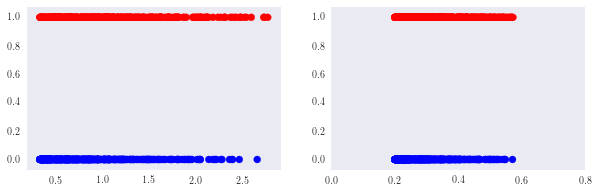

In [29]:
plt.figure(figsize = (10, 3))
plt.subplot(1,2, 1)
plt.scatter(df_train['mud']/df_train['sdrop'], df_train['label'], c = df_train['label'], cmap = 'bwr')
plt.grid(False)

plt.subplot(1,2, 2)
plt.scatter(df_train['mud'], df_train['label'], c = df_train['label'], cmap = 'bwr')
plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8])
plt.grid(False)
plt.show()

### Class distribution

In [30]:
label_count = df_train_all.groupby('label', as_index = False).count()
class_name = ['Rupture arrest', 'Rupture propagate']
count = list(label_count['height'])
print('Rupture propagate : {}, \nRupture arrest: {}'.format(count[0], count[1]))
print('Total number of data: {}'.format(np.sum(count)))
print('Class ratio for rupture propagation: {}'.format(count[0]/count[1]))

Rupture propagate : 1041, 
Rupture arrest: 559
Total number of data: 1600
Class ratio for rupture propagation: 1.8622540250447228


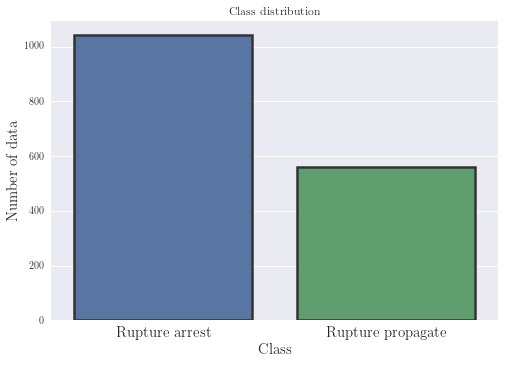

In [31]:
index = np.arange(len(class_name))
# plt.bar(class_name, count)
sns.barplot(x = class_name, y = count, linewidth = 2.5, errcolor = ".2", edgecolor = ".2")
plt.xlabel('Class', fontsize=15)
plt.ylabel('Number of data', fontsize=15)
plt.xticks(index, class_name, fontsize=15)
plt.title('Class distribution')
plt.show()

## Create model

#### 1. Hyperparameters

In [90]:
HIDDEN_LAYER_SIZE = 12
L2_REGULARIZER = 5
LEARNING_RATE = 0.0025
TRAINING_EPOCHS = 2000
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.30
POS_CLASS_RATIO = count[0]/count[1]
CLASS_WEIGHT = {0 : 1, 1: POS_CLASS_RATIO}

#### 2. Model setup

In [91]:
model = Sequential()
model.add(Dense(HIDDEN_LAYER_SIZE, 
                activation = 'relu',
                kernel_initializer = initializers.RandomNormal(mean = 0.0, stddev = 1, seed = 100),
                bias_initializer = 'Ones',
                input_shape = (8,),
                kernel_regularizer = regularizers.l2(L2_REGULARIZER),
                name = 'layer_1'))

adm_optz = optimizers.Adam(lr = LEARNING_RATE)

model.add(Dense(1, activation = "sigmoid", name = 'Output_layer'))
model.compile(optimizer = adm_optz, loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

#### 3. Train model

In [92]:
filepath = './logs/random_seed_'+ str(random_seed) +'_{epoch:02d}.hdf5'
checkpoint = ModelCheckpoint(filepath, verbose = 0, period = TRAINING_EPOCHS)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10)
              
callback_list = [checkpoint, early_stopping]

history = model.fit(xtrain_all, ytrain_all, 
                    batch_size = BATCH_SIZE, 
                    epochs = TRAINING_EPOCHS,
                    class_weight = CLASS_WEIGHT,
                    callbacks = callback_list,
                    validation_split = VALIDATION_SPLIT, 
                    verbose = 0)

## Training History

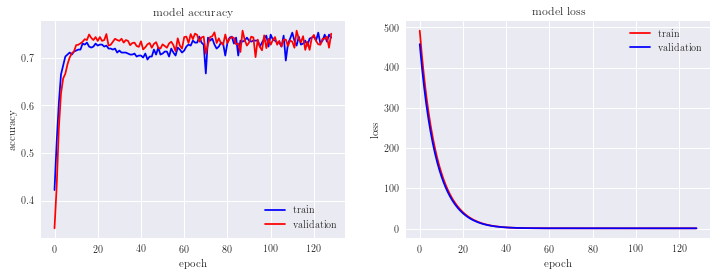

In [103]:
plt.figure(figsize= (12, 4))
# summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['val_acc'], 'b-')
plt.plot(history.history['acc'], 'r-')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'r-')
plt.plot(history.history['val_loss'], 'b-')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Threshold analysis based on training data'

In [94]:
ypred_train = model.predict(xtrain_all)

In [95]:
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc_score = roc_auc_score(ytrain_all, ypred_train)
fpr, tpr, thresholds = roc_curve(ytrain_all, ypred_train, pos_label = 1)

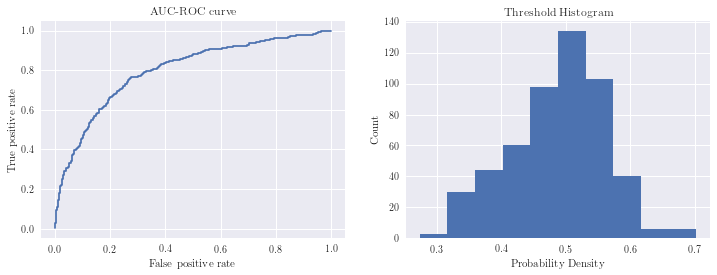

In [96]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2, 1)
plt.plot(fpr, tpr)
plt.title('AUC-ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.subplot(1, 2, 2)
plt.hist(thresholds)
plt.title('Threshold Histogram')
plt.xlabel('Probability Density')
plt.ylabel('Count')
plt.show()

In [97]:
def prediction(xdata, ydata, threshold = 0.50):
    ypred_test_prob = model.predict(xdata)
    ypred_bin = [1.0 if val > threshold  else 0.0 for val in ypred_test_prob]
    print('Accuracy of the model: {}\n'.format(accuracy_score(ydata, ypred_bin)))
    print('Classification report: \n{}\n'.format(classification_report(ydata, ypred_bin)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(ydata, ypred_bin)))

In [98]:
THRESHOLD = np.median(thresholds)
print(THRESHOLD)

0.494443


## Training data prediction

In [99]:
prediction(xtrain_all, ytrain_all, threshold = THRESHOLD)

Accuracy of the model: 0.741875

Classification report: 
             precision    recall  f1-score   support

        0.0       0.83      0.77      0.79      1041
        1.0       0.62      0.70      0.65       559

avg / total       0.75      0.74      0.75      1600


Confusion matrix: 
[[797 244]
 [169 390]]



## Test data prediction

In [107]:
prediction(xtest, ytest, threshold = 0.49)

Accuracy of the model: 0.8125

Classification report: 
             precision    recall  f1-score   support

        0.0       0.90      0.82      0.86       272
        1.0       0.68      0.80      0.73       128

avg / total       0.83      0.81      0.82       400


Confusion matrix: 
[[223  49]
 [ 26 102]]



In [55]:
# arr = np.array([0.088, 1.304, -136.062, 51.391, -126.715, 0.346, 0.448, 0.406]) # 1
arr = np.array([0.104, 1.146, -102.509, 58.619, -117.766, 0.484, 0.217, 0.296]) # 0
test_data = arr.reshape(1,8)
test_data = mms.fit_transform(test_data)
Y_pred = model.predict(test_data)
print(Y_pred)

[[0.44124234]]


In [13]:
weight = weights = model.get_weights()
layer_1_weights = weights[0]
layer_2_weights = weights[1]

act = test_data.dot(layer_1_weights) 

In [100]:
# %matplotlib notebook

from matplotlib import ticker

plt.figure(figsize=(20, 6))
# plt.rcParams.update({'font.size': 18})
model_weights = []
for i in range(len(random_seed)):
    filename = './logs/random_seed_'+ str(random_seed[i])+'_149.hdf5'
#     model.load_weights(filename)
    weights = model.get_weights()

    layer_1_weights = weights[0]    
    model_weights.append(layer_1_weights)
    plt.subplot(1,2, 1)
    plt.pcolormesh(np.transpose(layer_1_weights))
    labels = ['Height', 'Width', 'Stress xx', 'Stress xy', 'Stress yy', 'Dynamic Fric', 'Fric Drop', '$d_c$']
    plt.xticks([0.5+float(x) for x in range(0,8)], labels, rotation='vertical')
    plt.yticks([0.5+float(x) for x in range(0,12)], list(range(1,13)))
    plt.ylabel('Hidden Units')
#     plt.title('Acc=%s\n seed=%s'%(round(new_scores[i], 2), random_seed[i]))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)

    cb = plt.colorbar(orientation="vertical",fraction=0.05, pad=0.3)
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()
    
    # Layer two plot
    plt.subplot(1, 2, 2)
    layer_2_weights = weights[1]
    bb = np.reshape(layer_2_weights, (12, 1))
    plt.pcolormesh(bb)
    plt.xticks([0.5],['Output Unit'],rotation='vertical')
    plt.yticks([0.5+float(x) for x in range(0,12)], list(range(1,13)))
    cb = plt.colorbar(orientation="vertical",fraction=0.05, pad=0.3)
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()

plt.tight_layout()
# plt.savefig('weight_vs_features.eps')
plt.show()


<IPython.core.display.Javascript object>

### Training Size testing

In [143]:
def build_model(Xtrain, Ytrain):
    for i in range(len(train_size)):
        training_epochs = 150
        train_status = 'new' # retrain or new
        shape = [int(Xtrain.shape[1]), int(Ytrain.shape[1])]
        model = get_model(train_status, shape, random_seed[0])

#         filepath = './logs/random_seed_'+ str(random_seed[i]) +'_{epoch:02d}.hdf5'
#         checkpoint = ModelCheckpoint(filepath, verbose=0, save_weights_only=True, period=training_epochs)
    #   tbCallBack = TensorBoard(log_dir=path, histogram_freq=1, write_graph=True)

        model.fit(Xtrain, Ytrain, batch_size = 10, epochs = training_epochs, validation_data=(X_val, Y_val), verbose=0)
        scores = model.evaluate(X_test, Y_test, batch_size=10)
    return scores[1]

In [144]:
train_size = [1, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
no_data = np.shape(X_train)[0]
scores = []
for i, value in enumerate(train_size):
    size = int((no_data*value)/100)
    acc = build_model(X_train[:size, :], Y_train[:size, :])
    scores.append(acc)
    print('finished iteration : {} of {}, acc : {}'.format(i, len(train_size), acc))

 10/400 [..............................] - ETA: 0sfinished iteration : 1 of 2, acc : 0.8224999994039536


In [145]:
print('Test score : {}'.format(scores))

Test score : [0.82249999940395357, 0.82249999940395357]


In [7]:
import pickle, os
# plt.style.use('classic')
file_name="rupture_scores.pkl"

if os.path.isfile(file_name):
    file = open(file_name, 'rb')
    data = pickle.load(file)
else:
    data ={'scores':scores}
    file = open(file_name, 'wb')
    pickle.dump(data, file)
    file.close()

new_scores= []
indexs = []
for i in range(len(data['scores'])):
    new_scores.append(data['scores'][i][1])
    indexs.append(i)


# print(new_scores)
print(np.average(new_scores))
print(np.amax(new_scores))
print(np.amin(new_scores))

# plt.plot(indexs, new_scores, '-ok')
# plt.grid()
# plt.savefig('accuracy.eps')
# plt.show()

0.833166661163
0.854999993742
0.792499998957


In [59]:
shape = [int(X_train.shape[1]), int(Y_train.shape[1])]
loaded_model = get_model(train_status, shape, random_state)
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 12)                108       
_________________________________________________________________
Output_layer (Dense)         (None, 2)                 26        
Total params: 134
Trainable params: 134
Non-trainable params: 0
_________________________________________________________________


## Plot flatten weights heatmap

In [8]:
flatten_weights = []
for i in range(len(random_seed)):
    filename = './logs/random_seed_'+ str(random_seed[i])+'_999.hdf5'
    loaded_model.load_weights(filename)
    weights = loaded_model.get_weights()
    layer_1_weights = weights[0]
    layer_1_weights = layer_1_weights.flatten()
    flatten_weights.append(layer_1_weights)

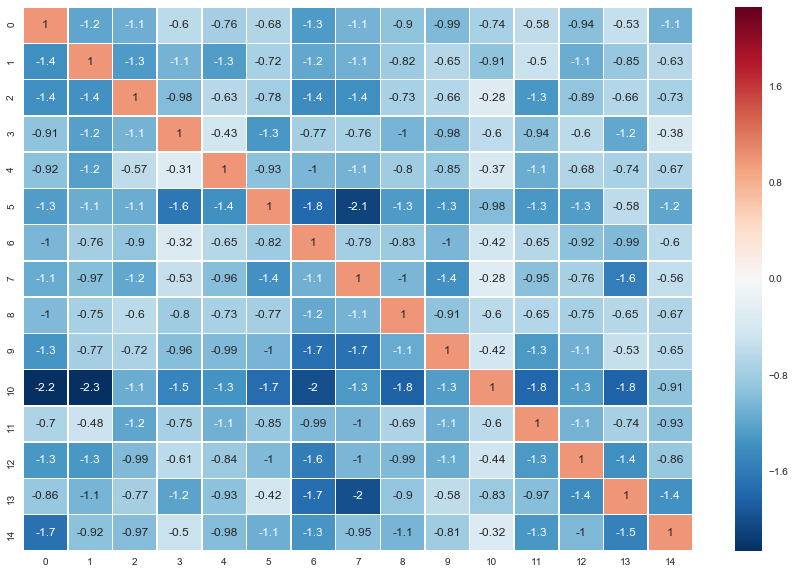

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
sns.set()

# Calculate r2_matrix
length = len(random_seed)
r2_matrix = np.zeros((length, length))
for i in range(length):
    for j in range(length):
        r2_matrix[i][j] = r2_score(flatten_weights[i], flatten_weights[j])

# Plot
# mask = np.ones_like(corr)
# mask[np.triu_indices_from(mask, 1)] = False
# mask=mask
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(r2_matrix, annot=True, linewidths=.5)
plt.savefig('unsorted_corr.eps')

## plot sorted weight heatmap

In [60]:
flatten_weights = []
for i in range(len(random_seed)):
    filename = './logs/random_seed_'+ str(random_seed[i])+'_999.hdf5'
    loaded_model.load_weights(filename)
    weights = loaded_model.get_weights()
    layer_1_weights = weights[0]
    layer_1_weights = np.sort(layer_1_weights.flatten())
    flatten_weights.append(layer_1_weights)

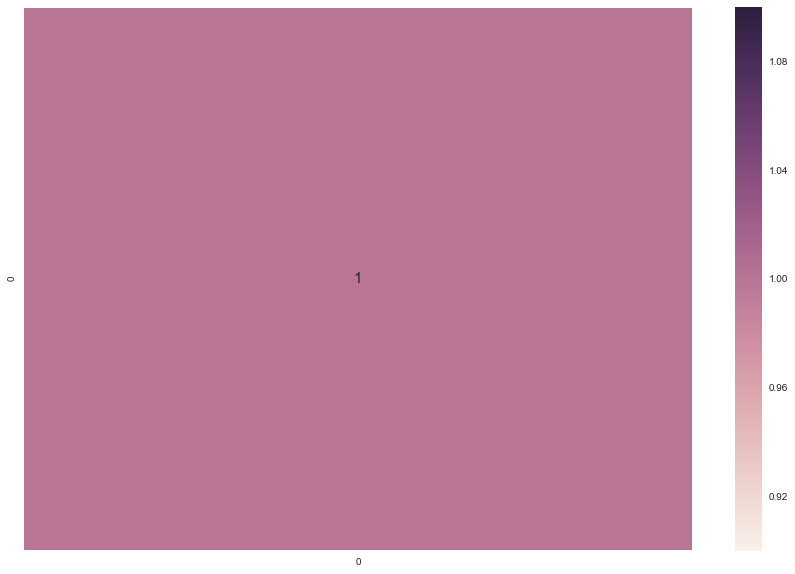

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
sns.set()

# Calculate r2_matrix
length = len(random_seed)
r2_matrix = np.zeros((length, length))
for i in range(length):
    for j in range(length):
        r2_matrix[i][j] = r2_score(flatten_weights[i], flatten_weights[j])

# Plot
plt.rcParams.update({'font.size': 15})
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(r2_matrix, annot=True, linewidths=.5)
plt.savefig('sorted_corr.eps')

## Prediction for different seed based models

In [15]:
from sklearn.metrics import precision_score, f1_score, fbeta_score, recall_score

score_f1 = []
score_precision = []
score_fbeta = []
score_recall = []

for i in range(len(random_seed)):
    filename = './logs/random_seed_'+ str(random_seed[i])+'_999.hdf5'
    loaded_model.load_weights(filename)
    Y_pred = loaded_model.predict(X_test)
    Y_test_class = np.argmax(Y_test, axis = 1)
    Y_pred_class = np.argmax(Y_pred, axis = 1)
    score_precision.append(precision_score(Y_test_class, Y_pred_class))
    score_f1.append(f1_score(Y_test_class, Y_pred_class))
    score_fbeta.append(fbeta_score(Y_test_class, Y_pred_class, 0.5))
    score_recall.append(recall_score(Y_test_class, Y_pred_class))

## Plot different evaluation metric

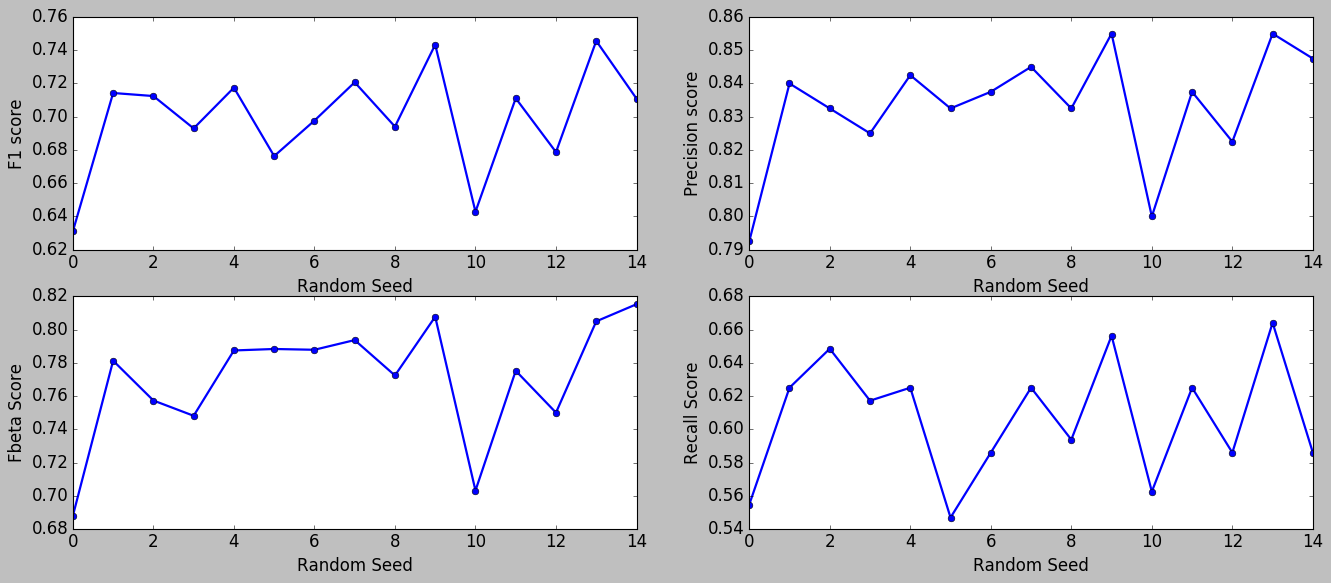

In [18]:
# plt.style.use('classic')
plt.rcParams.update({'font.size': 15})
plt.rc('lines', linewidth=2, color='k')
plt.figure(figsize=(20,8))

metric = [score_f1, score_acc, score_fbeta, score_recall]
ylabel = ['F1 score', 'Precision score', 'Fbeta Score', 'Recall Score']

for i in range(4):
    plt.subplot(2,2, i+1)
    plt.plot(metric[i], '-o')
    plt.xlabel('Random Seed')
    plt.ylabel(ylabel[i])
plt.savefig('scores.eps')
plt.show()

In [15]:
weight_mean =[]
weight_max =[]
weight_min =[]
for i in range(len(model_weights)):
    x = np.matrix(model_weights[i])
    weight_mean.append(x.mean())
    weight_max.append(x.max())
    weight_min.append(x.min())

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(weight_mean, '-r')

plt.subplot(1,3,2)
plt.plot(weight_max, '-k')

plt.subplot(1,3,3)
plt.plot(weight_min, '-b')
plt.show()
    

NameError: name 'model_weights' is not defined

In [71]:
Y_pred = loaded_model.predict(X_test)
Y_test_class = np.argmax(Y_test, axis = 1)
Y_pred_class = np.argmax(Y_pred, axis = 1)

In [72]:
print(accuracy_score(Y_test_class, Y_pred_class))
print(classification_report(Y_test_class, Y_pred_class))
print('---------- Confusion matrix ----------')
confusion_matrix(Y_test_class, Y_pred_class)

0.8475
             precision    recall  f1-score   support

          0       0.83      0.97      0.90       272
          1       0.90      0.59      0.71       128

avg / total       0.86      0.85      0.84       400

---------- Confusion matrix ----------


array([[264,   8],
       [ 53,  75]])

## Plot accuracy 

In [44]:
#print(history.history.keys())

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(20,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy', size=16)
plt.ylabel('Accuracy', size=16)
plt.xlabel('Epoch', size=16)
plt.legend(['Training', 'Validation'], loc='lower right')


NameError: name 'history' is not defined

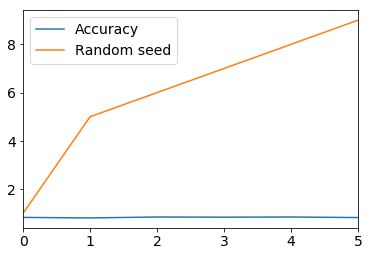

In [45]:
# model accuracy at different random seed
data = pd.DataFrame({'Random seed':[1, 5, 6, 7, 8, 9],
                     'Accuracy' : [0.8275, 0.8075, 0.845, 0.8375, 0.845, 0.8225]})
data.plot()

### best seed model

In [ ]:
random_seed = 100